# Market Analysis & Trend Prediction for Land Transactions
This notebook builds a complete, decision-grade market analysis and ML forecasting pipeline for land investments in Bugesera. It covers data engineering, visualization, modeling, evaluation, and future price projections.

**Objectives**
- Identify the most profitable locations to invest
- Detect market price trends
- Explain key factors influencing land price
- Predict future price progression

In [1]:
# Imports & configuration
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Data Loading
Load the Bugesera market transactions dataset.

In [2]:
# Load dataset (required path line)
try:
    df = pd.read_csv("bugesera_sample_market_trends.csv")
except FileNotFoundError:
    df = pd.read_csv("dataset/bugesera_sample_market_trends.csv")

display(df.head())
print("Rows:", len(df))
df.info()

,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,start_date,Year
0,Eastern,Bugesera,Gashora,Biryogo,Kivugiza,5/07/01/01/1004,231.0,Gutura,Transfer by Voluntary Sale,450000.0,02/09/2023,NaN
1,Eastern,Bugesera,Gashora,Biryogo,Kanyonyomba,5/07/01/01/1015,341.0,Gutura,Transfer by Voluntary Sale,500000.0,28/03/2023,NaN
2,Eastern,Bugesera,Gashora,Biryogo,Biryogo,5/07/01/01/1039,116.0,Gutura,Transfer by Voluntary Sale,2800000.0,28/04/2023,NaN
3,Eastern,Bugesera,Gashora,Biryogo,Kagarama,5/07/01/01/104,1276.0,Ubuhinzi,Transfer by Voluntary Sale,3000000.0,10/08/2022,NaN
4,Eastern,Bugesera,Gashora,Biryogo,Kagarama,5/07/01/01/106,492.0,Ubuhinzi,Transfer by Voluntary Sale,3550000.0,19/12/2023,NaN


Rows: 264838
<class 'pandas.DataFrame'>
RangeIndex: 264838 entries, 0 to 264837
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   provincename               264838 non-null  str    
 1   districtname               264838 non-null  str    
 2   sectorname                 264838 non-null  str    
 3   cellname                   264838 non-null  str    
 4   village                    264838 non-null  str    
 5   upi                        264837 non-null  str    
 6   size                       264837 non-null  float64
 7   land_use_name_kinyarwanda  264837 non-null  str    
 8   transaction_type_name      264838 non-null  str    
 9   sale_price                 262076 non-null  float64
 10  start_date                 264838 non-null  str    
 11  Year                       0 non-null       float64
dtypes: float64(3), str(9)
memory usage: 24.2 MB


## Data Cleaning
Clean missing `Year` and `start_date`, convert dates, remove duplicates, and standardize numeric fields. Each step is explained inline.

In [3]:
df_clean = df.copy()

# Standardize column names (defensive)
df_clean.columns = [c.strip() for c in df_clean.columns]

# Parse dates (day-first to match dataset formatting like 02/09/2023)
df_clean["start_date"] = pd.to_datetime(df_clean["start_date"], errors="coerce", dayfirst=True)

# Clean numeric columns
df_clean["sale_price"] = pd.to_numeric(df_clean["sale_price"], errors="coerce")
df_clean["size"] = pd.to_numeric(df_clean["size"], errors="coerce")

# Fill missing Year using start_date; otherwise keep as NaN
df_clean["Year"] = pd.to_numeric(df_clean["Year"], errors="coerce")
df_clean.loc[df_clean["Year"].isna(), "Year"] = df_clean.loc[df_clean["Year"].isna(), "start_date"].dt.year

# If start_date missing but Year exists, impute start_date as mid-year
missing_start = df_clean["start_date"].isna() & df_clean["Year"].notna()
df_clean.loc[missing_start, "start_date"] = pd.to_datetime(df_clean.loc[missing_start, "Year"].astype(int).astype(str) + "-07-01")

# Drop rows with missing critical fields
df_clean = df_clean.dropna(subset=["sale_price", "size", "start_date"])

# Remove duplicates by UPI, keep latest transaction by date
df_clean = df_clean.sort_values("start_date").drop_duplicates(subset=["upi"], keep="last")

print("After cleaning:", df_clean.shape)
display(df_clean.head())

After cleaning: (244693, 12)


,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,start_date,Year
245580,Western,Rubavu,Cyanzarwe,Ryabizige,Musene,3/03/03/08/4008,597.0,Ubuhinzi,Transfer by Voluntary Sale,1000000.0,2022-01-01,2022.0
254370,Western,Rubavu,Rugerero,Muhira,Gatebe II,3/03/12/04/1909,435.0,Ubuhinzi,Transfer by Voluntary Sale,1000000.0,2022-01-01,2022.0
245295,Western,Rubavu,Cyanzarwe,Kinyanzovu,Kibaya,3/03/03/04/276,1024.0,Ubuhinzi,Transfer by Voluntary Sale,3100000.0,2022-01-01,2022.0
254129,Western,Rubavu,Rugerero,Kabilizi,Amahoro,3/03/12/03/2869,1335.0,Ubuhinzi,Transfer by Voluntary Sale,1000000.0,2022-01-01,2022.0
261369,Western,Rutsiro,Kigeyo,Nyagahinika,Nteko,3/02/03/03/7890,6865.0,Ubuhinzi,Transfer by Voluntary Sale,5000000.0,2022-01-01,2022.0


## Feature Engineering
Create derived features including `price_per_size`, time features, area-level aggregations, rolling averages, and handle outliers.

In [4]:
df_feat = df_clean.copy()

# Time features
df_feat["year"] = df_feat["start_date"].dt.year
df_feat["month"] = df_feat["start_date"].dt.month
df_feat["year_month"] = df_feat["start_date"].dt.to_period("M").astype(str)

# Derived value metrics
df_feat["price_per_size"] = df_feat["sale_price"] / df_feat["size"].replace(0, np.nan)

# Area-level aggregations (mean prices, counts)
district_agg = df_feat.groupby("districtname").agg(
    district_avg_price=("sale_price", "mean"),
    district_txn_count=("upi", "count")
).reset_index()
sector_agg = df_feat.groupby("sectorname").agg(
    sector_avg_price=("sale_price", "mean"),
    sector_txn_count=("upi", "count")
).reset_index()
cell_agg = df_feat.groupby("cellname").agg(
    cell_avg_price=("sale_price", "mean"),
    cell_txn_count=("upi", "count")
).reset_index()

df_feat = df_feat.merge(district_agg, on="districtname", how="left")
df_feat = df_feat.merge(sector_agg, on="sectorname", how="left")
df_feat = df_feat.merge(cell_agg, on="cellname", how="left")

# Rolling averages by sector and cell (3-transaction window)
df_feat = df_feat.sort_values("start_date")
df_feat["sector_roll_3"] = df_feat.groupby("sectorname")["sale_price"].transform(lambda x: x.rolling(3, min_periods=1).mean())
df_feat["cell_roll_3"] = df_feat.groupby("cellname")["sale_price"].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Outlier handling using IQR on price_per_size
q1, q3 = df_feat["price_per_size"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
df_feat = df_feat[(df_feat["price_per_size"] >= lower) & (df_feat["price_per_size"] <= upper)]

print("After feature engineering:", df_feat.shape)
display(df_feat.head())

After feature engineering: (215318, 24)


,provincename,districtname,sectorname,cellname,village,upi,size,land_use_name_kinyarwanda,transaction_type_name,sale_price,...,year_month,price_per_size,district_avg_price,district_txn_count,sector_avg_price,sector_txn_count,cell_avg_price,cell_txn_count,sector_roll_3,cell_roll_3
0,Western,Rubavu,Cyanzarwe,Ryabizige,Musene,3/03/03/08/4008,597.0,Ubuhinzi,Transfer by Voluntary Sale,1000000.0,...,2022-01,1675.041876,5.874388e+06,10997,2.840695e+06,633,1.987500e+06,76,1000000.0,1000000.0
36,Western,Rubavu,Rugerero,Rugerero,Kabarora,3/03/12/05/2736,238.0,Ubuhinzi,Transfer by Voluntary Sale,1500000.0,...,2022-01,6302.521008,5.874388e+06,10997,5.005695e+06,1982,5.511735e+06,498,1500000.0,1500000.0
37,Western,Rutsiro,Mukura,Mwendo,Nyove,3/02/06/06/3232,556.0,Ubuhinzi,Transfer by Voluntary Sale,1300000.0,...,2022-01,2338.129496,2.495657e+06,4299,1.206033e+12,995,4.139743e+06,1069,1300000.0,1300000.0
38,Western,Rubavu,Rubavu,Buhaza,Murambi,3/03/11/01/1195,619.0,Ubuhinzi,Transfer by Voluntary Sale,6000000.0,...,2022-01,9693.053312,5.874388e+06,10997,5.059063e+06,2971,4.572399e+06,471,6000000.0,6000000.0
39,Western,Rutsiro,Mukura,Mwendo,Nyove,3/02/06/06/6087,2508.0,Ubuhinzi,Transfer by Voluntary Sale,700000.0,...,2022-01,279.106858,2.495657e+06,4299,1.206033e+12,995,4.139743e+06,1069,1000000.0,1000000.0


## Visualization
Explore distributions, relationships, and spatial/temporal patterns. Each chart is followed by insights.

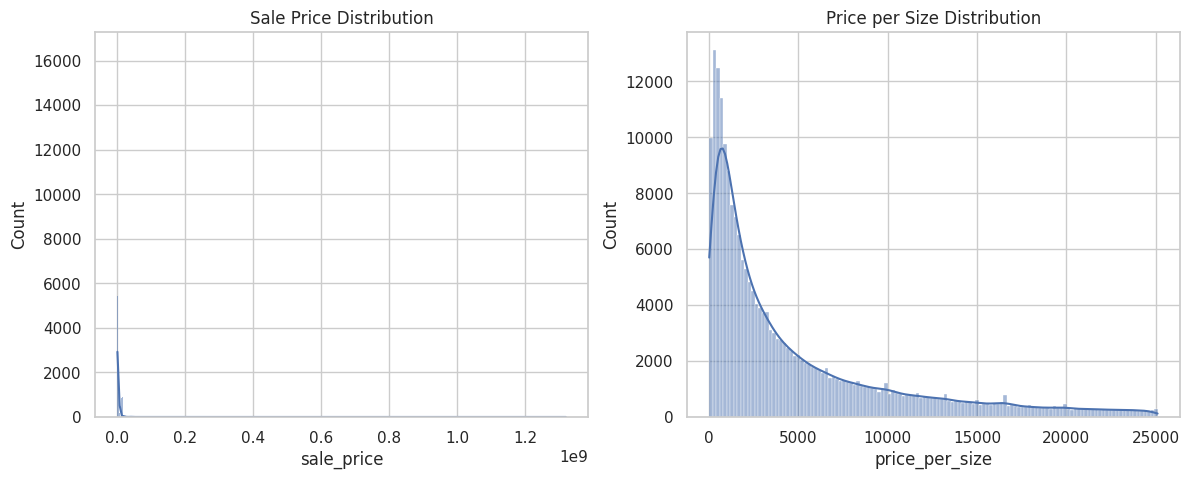

Insight: Distributions reveal price concentration and potential skew/outliers.


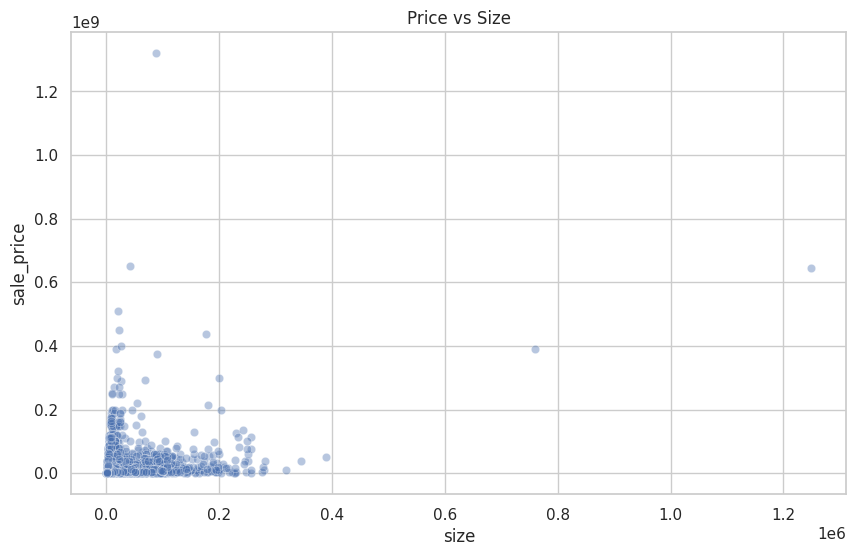

Insight: Observe whether price scales proportionally with land size.


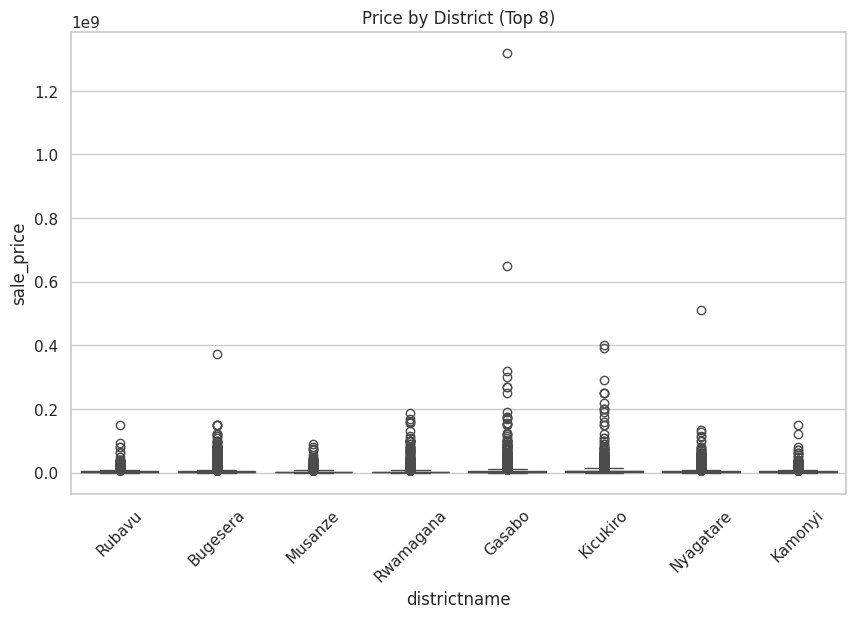

Insight: Districts with higher median prices indicate stronger demand.


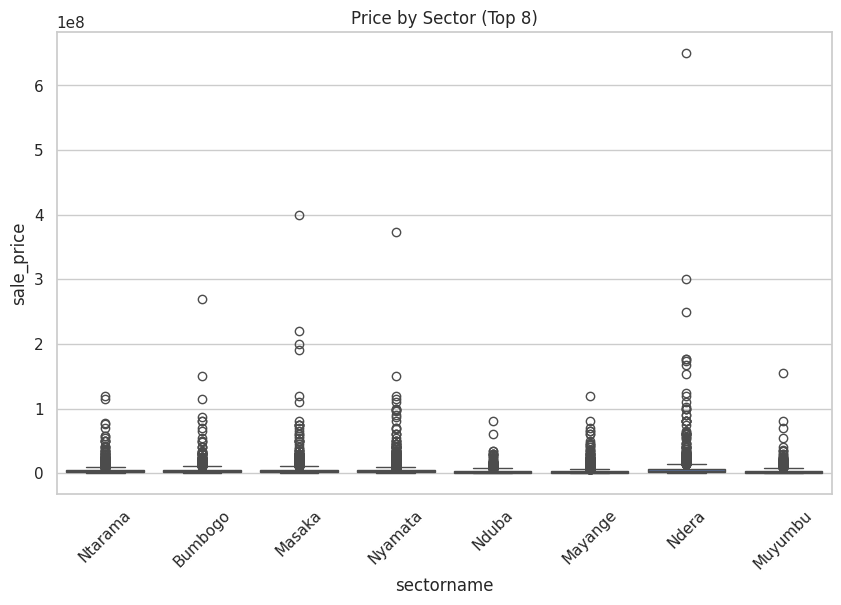

Insight: Sector-level price dispersion shows market heterogeneity.


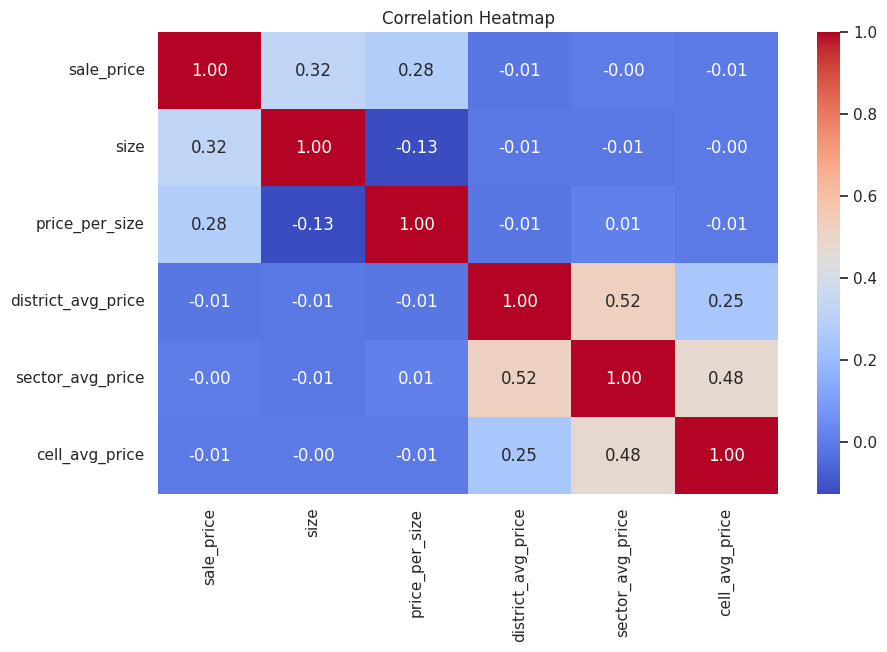

Insight: Identifies which numeric factors track price most strongly.


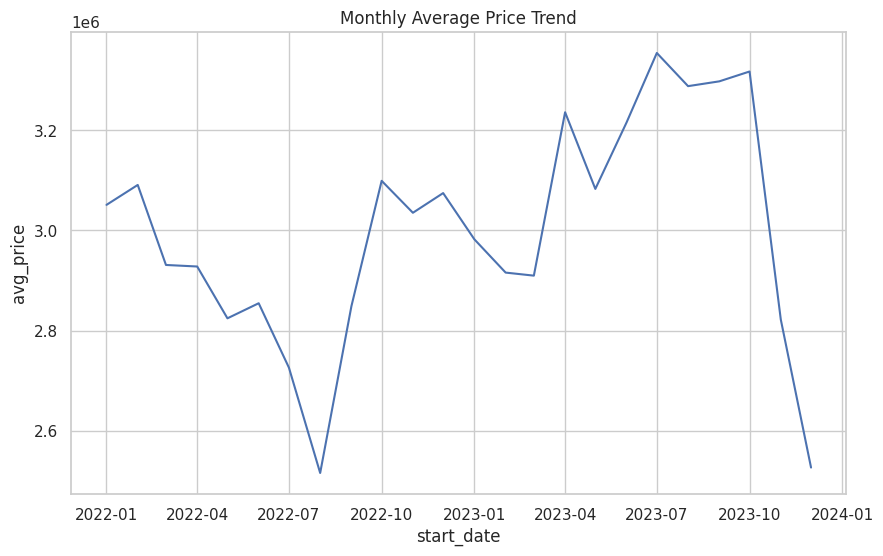

Insight: Detects uptrends or downturns in the market over time.


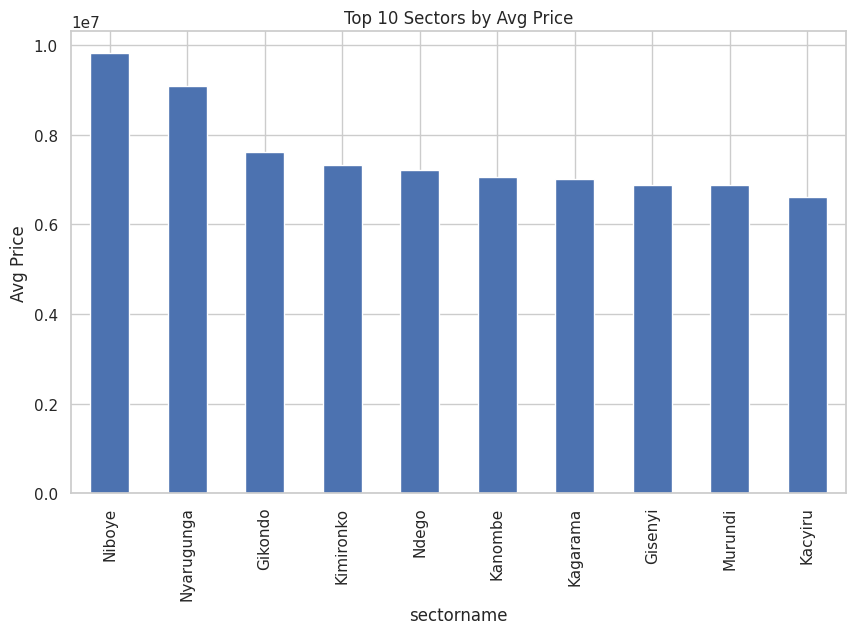

Insight: Highest-average sectors are likely premium investment zones.


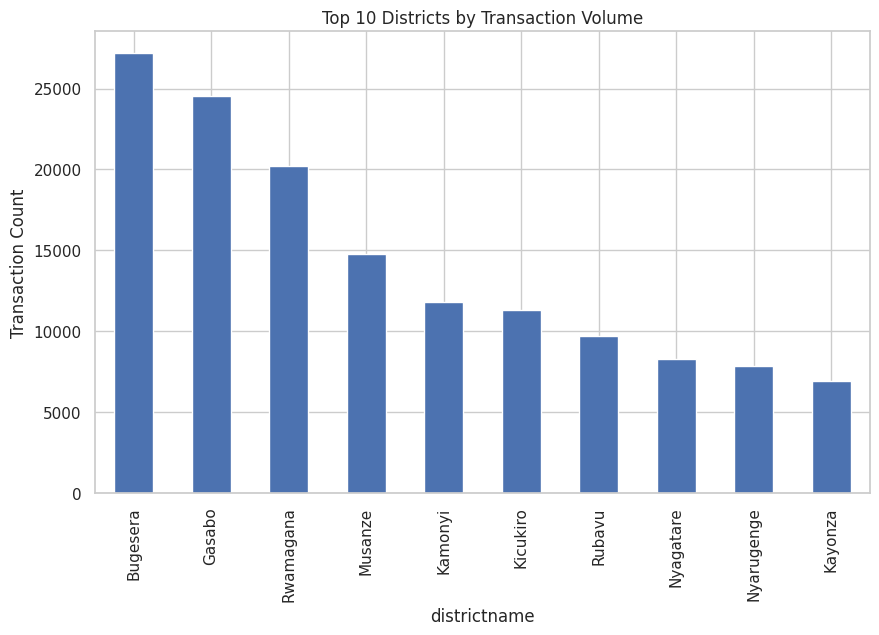

Insight: High volume indicates liquidity and market activity.


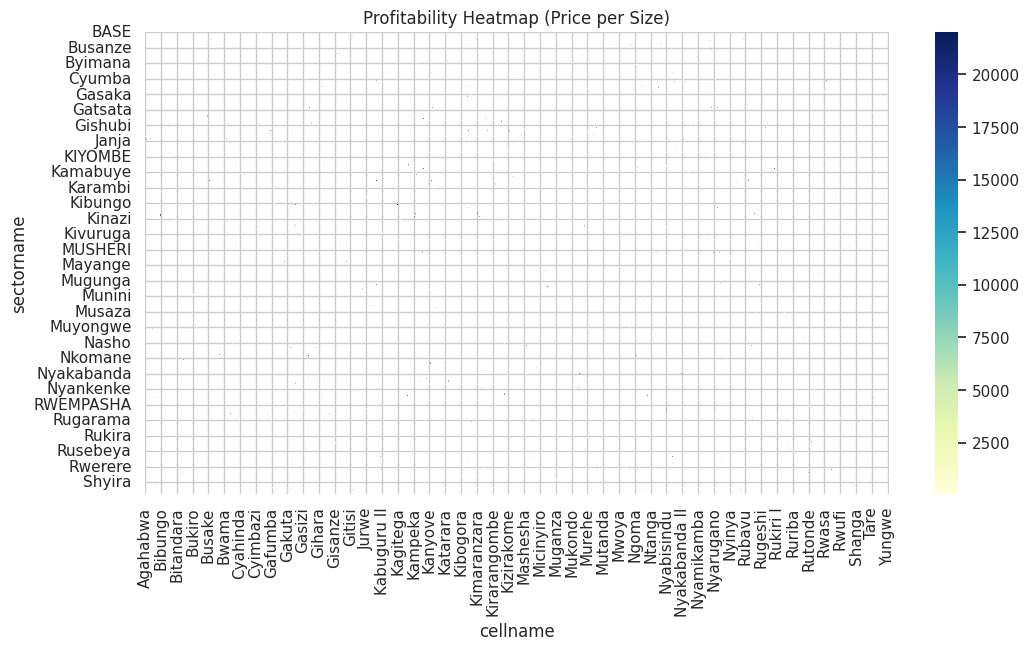

Insight: Hotter cells/sectors suggest strong profitability per unit size.


In [5]:
# Price distribution histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_feat["sale_price"], kde=True, ax=axes[0])
axes[0].set_title("Sale Price Distribution")
sns.histplot(df_feat["price_per_size"], kde=True, ax=axes[1])
axes[1].set_title("Price per Size Distribution")
plt.show()
print("Insight: Distributions reveal price concentration and potential skew/outliers.")

# Price vs size scatter
sns.scatterplot(data=df_feat, x="size", y="sale_price", alpha=0.4)
plt.title("Price vs Size")
plt.show()
print("Insight: Observe whether price scales proportionally with land size.")

# Boxplots by district and sector (top categories for readability)
top_districts = df_feat["districtname"].value_counts().head(8).index
sns.boxplot(data=df_feat[df_feat["districtname"].isin(top_districts)], x="districtname", y="sale_price")
plt.title("Price by District (Top 8)")
plt.xticks(rotation=45)
plt.show()
print("Insight: Districts with higher median prices indicate stronger demand.")

top_sectors = df_feat["sectorname"].value_counts().head(8).index
sns.boxplot(data=df_feat[df_feat["sectorname"].isin(top_sectors)], x="sectorname", y="sale_price")
plt.title("Price by Sector (Top 8)")
plt.xticks(rotation=45)
plt.show()
print("Insight: Sector-level price dispersion shows market heterogeneity.")

# Correlation heatmap
numeric_cols = ["sale_price", "size", "price_per_size", "district_avg_price", "sector_avg_price", "cell_avg_price"]
corr = df_feat[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
print("Insight: Identifies which numeric factors track price most strongly.")

# Time series price trend
monthly = df_feat.groupby(df_feat["start_date"].dt.to_period("M")).agg(avg_price=("sale_price", "mean")).reset_index()
monthly["start_date"] = monthly["start_date"].dt.to_timestamp()
sns.lineplot(data=monthly, x="start_date", y="avg_price")
plt.title("Monthly Average Price Trend")
plt.show()
print("Insight: Detects uptrends or downturns in the market over time.")

# Average price per location ranking (top 10 sectors)
sector_rank = df_feat.groupby("sectorname")["sale_price"].mean().sort_values(ascending=False).head(10)
sector_rank.plot(kind="bar", title="Top 10 Sectors by Avg Price")
plt.ylabel("Avg Price")
plt.show()
print("Insight: Highest-average sectors are likely premium investment zones.")

# Transaction volume by area (district)
district_volume = df_feat["districtname"].value_counts().head(10)
district_volume.plot(kind="bar", title="Top 10 Districts by Transaction Volume")
plt.ylabel("Transaction Count")
plt.show()
print("Insight: High volume indicates liquidity and market activity.")

# Profitability heatmap (sector vs cell)
pivot = df_feat.pivot_table(index="sectorname", columns="cellname", values="price_per_size", aggfunc="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title("Profitability Heatmap (Price per Size)")
plt.show()
print("Insight: Hotter cells/sectors suggest strong profitability per unit size.")

## Market Insights
Compute profitability, growth, volatility, liquidity, land-use impact, and transaction-type effects.

In [6]:
# Top profitable sectors and cells by price_per_size
top_sectors_profit = df_feat.groupby("sectorname")["price_per_size"].mean().sort_values(ascending=False).head(10)
top_cells_profit = df_feat.groupby("cellname")["price_per_size"].mean().sort_values(ascending=False).head(10)
display(top_sectors_profit)
display(top_cells_profit)

# Fastest growing regions by yearly price trend (simple linear slope)
yearly_sector = df_feat.groupby(["sectorname", "year"])["sale_price"].mean().reset_index()
growth_scores = []
for sector, group in yearly_sector.groupby("sectorname"):
    if group["year"].nunique() < 2:
        continue
    slope = np.polyfit(group["year"], group["sale_price"], 1)[0]
    growth_scores.append((sector, slope))
growth_df = pd.DataFrame(growth_scores, columns=["sectorname", "price_slope"]).sort_values("price_slope", ascending=False)
display(growth_df.head(10))

# Volatility by location (std of price_per_size)
volatility = df_feat.groupby("sectorname")["price_per_size"].std().sort_values(ascending=True)
display(volatility.head(10))

# Liquidity indicator (transaction frequency)
liquidity = df_feat["sectorname"].value_counts().rename("txn_count")
display(liquidity.head(10))

# Land use impact on price
land_use_price = df_feat.groupby("land_use_name_kinyarwanda")["price_per_size"].mean().sort_values(ascending=False)
display(land_use_price.head(10))

# Size vs price efficiency (price_per_size by size quantile)
df_feat["size_bin"] = pd.qcut(df_feat["size"], 4, duplicates="drop")
size_eff = df_feat.groupby("size_bin")["price_per_size"].mean()
display(size_eff)

# Transaction type effect on price
txn_type_effect = df_feat.groupby("transaction_type_name")["price_per_size"].mean().sort_values(ascending=False)
display(txn_type_effect)

sectorname
Kicukiro      18453.084628
Nyarugunga    14817.257928
Gikondo       14042.239459
Kagarama      13959.233647
Kimihurura    13872.700050
Kanombe       13796.873058
Nyakabanda    13241.880764
Niboye        12967.997625
Gitega        12688.012941
Kacyiru       12277.553891
Name: price_per_size, dtype: float64

cellname
Kabuguru II      19111.817756
Kamutwa          18163.615618
Rukiri I         16740.209923
Kabuga I         15766.546019
Kimihurura       15363.420462
Kamashashi       15212.770607
Cyimo            15133.333278
Nyakabanda II    15028.551616
Kanserege        14773.453186
Mpenge           14644.299541
Name: price_per_size, dtype: float64

,sectorname,price_slope
72,Gikondo,3.154887e+06
238,Mushikiri,2.992958e+06
152,Kimihurura,2.839471e+06
54,Gashaki,2.796479e+06
307,Nzahaha,2.699331e+06
111,Kacyiru,1.901128e+06
118,Kamegeri,1.751642e+06
251,Mwiri,1.664479e+06
386,Zaza,1.641152e+06
31,Cyabakamyi,1.473187e+06


sectorname
Gishubi     1193.878328
Rubaya      1205.752119
Rwankuba    1237.505106
Rushaki     1330.388085
Ntyazo      1464.165894
Ruganda     1510.055915
Kibumbwe    1568.859435
Kansi       1590.816984
Mutuntu     1618.537250
Zaza        1639.788279
Name: price_per_size, dtype: float64

sectorname
Nyamata    7181
Mayange    6180
Bumbogo    5209
Muyumbu    4932
Masaka     4688
Ndera      4210
Ntarama    4203
Nduba      4132
Runda      3880
Gahanga    3608
Name: txn_count, dtype: int64

land_use_name_kinyarwanda
Inganda(ubutaka bwa Leta bugize umutungo rusange)    12347.180077
Gutura - Ubutaka bwite bw' Akarere                   12040.072768
Gutura - Ubutaka bwite bw'umujyi wa Kigali            9703.811188
Agace k'ubuhumekero                                   9656.036945
UBUCURUZI - UBUTAKA BWITE BW'AKARERE                  9499.557526
Inganda - Ubutaka bwite bw' Akarere                   8847.796746
Gutura (Ubutaka bwite bwa Leta)                       8403.499356
Inganda                                               8327.994404
Ubucuruzi - Ubutaka bwite bw' Akarere                 8057.410085
Ibikorwa by'ubucuruzi                                 8042.629495
Name: price_per_size, dtype: float64

size_bin
(3.999, 349.0]         8644.090036
(349.0, 594.0]         5932.901648
(594.0, 1151.0]        3558.478874
(1151.0, 1249125.0]    1448.695000
Name: price_per_size, dtype: float64

transaction_type_name
Transfer by Voluntary Sale    4898.323908
Name: price_per_size, dtype: float64

## Investment Ranking
Rank investment zones using a composite score (profitability, growth, liquidity, volatility).

In [7]:
# Composite scoring by sector
sector_stats = df_feat.groupby("sectorname").agg(
    avg_pps=("price_per_size", "mean"),
    growth=("sector_roll_3", "mean"),
    liquidity=("sector_txn_count", "mean"),
    volatility=("price_per_size", "std")
).reset_index()

def min_max(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-9)

sector_stats["avg_pps_n"] = min_max(sector_stats["avg_pps"])
sector_stats["growth_n"] = min_max(sector_stats["growth"])
sector_stats["liquidity_n"] = min_max(sector_stats["liquidity"])
sector_stats["volatility_n"] = 1 - min_max(sector_stats["volatility"].fillna(sector_stats["volatility"].median()))

sector_stats["investment_score"] = (
    0.35 * sector_stats["avg_pps_n"] +
    0.30 * sector_stats["growth_n"] +
    0.20 * sector_stats["liquidity_n"] +
    0.15 * sector_stats["volatility_n"]
)

top_investment_sectors = sector_stats.sort_values("investment_score", ascending=False).head(10)
display(top_investment_sectors[["sectorname", "investment_score", "avg_pps", "growth", "liquidity", "volatility"]])

,sectorname,investment_score,avg_pps,growth,liquidity,volatility
70,Gihundwe,0.511683,5695.970645,2.699055e+25,1319.0,5336.207361
144,Kicukiro,0.405576,18453.084628,4.950417e+07,157.0,6776.104640
292,Nyamata,0.399024,6771.961911,5.561703e+06,7579.0,5294.217032
10,Bumbogo,0.395554,9006.725334,3.076320e+11,6736.0,6713.600212
124,Kanombe,0.379180,13796.873058,1.312528e+07,2702.0,6916.092412
46,Gahanga,0.369837,9932.572904,2.238262e+11,5038.0,6654.472420
192,Masaka,0.364806,8204.228632,7.058885e+06,5888.0,6293.040268
343,Runda,0.356629,9599.219955,6.008622e+06,4734.0,6577.056862
262,Ndera,0.356107,9263.155557,1.900331e+11,5137.0,6838.234378
304,Nyarugunga,0.353608,14817.257928,2.790797e+07,1102.0,7101.346546


## Model Training
Train two supervised models to predict `sale_price` using engineered features and categorical encoding.

In [ ]:
# Define features and target
target = "sale_price"
feature_cols = [
    "provincename", "districtname", "sectorname", "cellname", "village",
    "land_use_name_kinyarwanda", "transaction_type_name",
    "size", "year", "month",
    "district_avg_price", "sector_avg_price", "cell_avg_price",
    "district_txn_count", "sector_txn_count", "cell_txn_count",
    "sector_roll_3", "cell_roll_3"
]

model_data = df_feat.dropna(subset=feature_cols + [target]).copy()
X = model_data[feature_cols]
y = model_data[target]

cat_cols = [
    "provincename", "districtname", "sectorname", "cellname", "village",
    "land_use_name_kinyarwanda", "transaction_type_name"
]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Random Forest (tree-based)
rf = RandomForestRegressor(random_state=42)
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])
rf_grid = {
    "model__n_estimators": [150, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5]
}
rf_search = GridSearchCV(rf_pipe, rf_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
rf_search.fit(X_train, y_train)

# Model 2: ElasticNet (linear regression)
en = ElasticNet(random_state=42)
en_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", en)])
en_grid = {
    "model__alpha": [0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.5, 0.9]
}
en_search = GridSearchCV(en_pipe, en_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
en_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best ElasticNet params:", en_search.best_params_)

# Cross-validation (MAE)
rf_cv = -cross_val_score(rf_search.best_estimator_, X_train, y_train, cv=3, scoring="neg_mean_absolute_error").mean()
en_cv = -cross_val_score(en_search.best_estimator_, X_train, y_train, cv=3, scoring="neg_mean_absolute_error").mean()
print("RF CV MAE:", rf_cv)
print("ElasticNet CV MAE:", en_cv)

### Feature Importance
Identify key drivers of price using the tree-based model.

In [ ]:
# Extract feature names from preprocessing
feature_names = rf_best.named_steps["preprocess"].get_feature_names_out()
importances = rf_best.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False).head(20)
display(fi)

sns.barplot(data=fi, y="feature", x="importance")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()
print("Insight: Top features indicate the strongest drivers of land price.")

## Model Architecture
**Input Features**
- Categorical: provincename, districtname, sectorname, cellname, village, land_use_name_kinyarwanda, transaction_type_name
- Numeric: size, year, month, district/sector/cell average price, transaction counts, rolling price averages

**Encoding & Scaling**
- Categorical: One-Hot Encoding
- Numeric: StandardScaler

**Models**
1. **RandomForestRegressor** (tree-based ensemble)
   - No activation functions (non-neural model)
   - Optimization: bootstrap aggregation with impurity minimization
   - Loss: MSE at split level
2. **ElasticNet** (linear regression with L1/L2)
   - Optimization: coordinate descent
   - Loss: MSE + L1/L2 penalties

**Training Configuration**
- Train/validation split: 80/20
- Cross-validation: 3-fold
- Hyperparameter tuning: GridSearchCV
- Metrics: MAE, RMSE, R², MAPE

## Performance Metrics
Evaluate model performance using MAE, RMSE, R², and MAPE.

In [ ]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    return mae, rmse, r2, mape

rf_best = rf_search.best_estimator_
en_best = en_search.best_estimator_

rf_pred = rf_best.predict(X_test)
en_pred = en_best.predict(X_test)

rf_metrics = regression_metrics(y_test, rf_pred)
en_metrics = regression_metrics(y_test, en_pred)

metrics_df = pd.DataFrame([
    ["RandomForest", *rf_metrics],
    ["ElasticNet", *en_metrics]
], columns=["Model", "MAE", "RMSE", "R2", "MAPE"])
display(metrics_df)
print("Interpretation: Lower MAE/RMSE/MAPE and higher R² indicate better fit.")

## Forecasting
Use time-based regression and rolling trends to project future prices by sector and overall.

In [ ]:
from sklearn.linear_model import LinearRegression

# Aggregate monthly average prices
monthly = df_feat.groupby(df_feat["start_date"].dt.to_period("M")).agg(avg_price=("sale_price", "mean")).reset_index()
monthly["start_date"] = monthly["start_date"].dt.to_timestamp()
monthly["t"] = np.arange(len(monthly))

# Fit time-based regression
lin = LinearRegression()
lin.fit(monthly[["t"]], monthly["avg_price"])
monthly["pred"] = lin.predict(monthly[["t"]])

# Forecast next 12 months
future_t = np.arange(len(monthly), len(monthly) + 12)
future_dates = pd.date_range(monthly["start_date"].max() + pd.offsets.MonthBegin(1), periods=12, freq="MS")
future_pred = lin.predict(future_t.reshape(-1, 1))
future_df = pd.DataFrame({"start_date": future_dates, "avg_price_pred": future_pred})

plt.plot(monthly["start_date"], monthly["avg_price"], label="Actual")
plt.plot(monthly["start_date"], monthly["pred"], label="Fitted")
plt.plot(future_df["start_date"], future_df["avg_price_pred"], label="Forecast", linestyle="--")
plt.title("Overall Price Forecast")
plt.legend()
plt.show()

# Next-year expected price range (using residual std)
residual_std = (monthly["avg_price"] - monthly["pred"]).std()
future_df["lower"] = future_df["avg_price_pred"] - 1.96 * residual_std
future_df["upper"] = future_df["avg_price_pred"] + 1.96 * residual_std
display(future_df.head())

# Sector-level forecast for top 5 sectors by volume
top5 = df_feat["sectorname"].value_counts().head(5).index
plt.figure(figsize=(12, 6))
for sector in top5:
    sec = df_feat[df_feat["sectorname"] == sector].groupby(df_feat["start_date"].dt.to_period("M")).agg(avg_price=("sale_price", "mean")).reset_index()
    sec["start_date"] = sec["start_date"].dt.to_timestamp()
    sec["t"] = np.arange(len(sec))
    if len(sec) < 3:
        continue
    lin.fit(sec[["t"]], sec["avg_price"])
    sec_pred = lin.predict(sec[["t"]])
    plt.plot(sec["start_date"], sec_pred, label=sector)
plt.title("Sector-Level Price Trajectories (Fitted)")
plt.legend()
plt.show()

## Investment Recommendations
Summarize decision-grade recommendations based on profitability, growth, and liquidity.

In [ ]:
# Final recommendation table
recommendations = top_investment_sectors.copy()
recommendations["notes"] = np.where(recommendations["avg_pps"] > recommendations["avg_pps"].median(), "High profitability", "Moderate profitability")
display(recommendations[["sectorname", "investment_score", "avg_pps", "liquidity", "volatility", "notes"]])

print("Recommendation Summary:")
print("- Prioritize top-ranked sectors with high price_per_size and strong liquidity.")
print("- Favor areas with positive growth trends and manageable volatility.")
print("- Use forecasted ranges to time entry points over the next 12 months.")